# Grid price impact

In [2]:
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numba import njit, prange

In [3]:
%config InlineBackend.figure_format = "retina"

In [87]:
@njit
def sigmoid(z): return 1 / (1 + np.exp(-z))

@njit
def price_step(price, signal, action, sigma, sigma_signal, delta, price_impact):
    sign_signal = 2 * (np.random.uniform() > 0.5) - 1
    signal_next = (
        + signal + sigma_signal * np.sqrt(delta) * sign_signal
    )
    signal_next = np.round(signal_next)
    
    
    pr = sigmoid(action * price_impact)
    sign = np.random.uniform() > 1 - pr
    sign = 2 * sign - 1
        
    price_next = price + sigma * np.sqrt(delta) * sign + signal_next
    price_next = np.maximum(0.0, price_next) # Minimum price is 0.0
    return price_next, signal_next
    

@njit
def price_process(
    seed, num_steps, price_init, actions, sigma=1.0, sigma_signal=1.0, delta=1.0, price_impact=1.0
):
    """
    Price process when the actions are already known
    """
    np.random.seed(seed)
    prices = np.zeros(num_steps)
    prices[0] = price_init

    signals = np.zeros(num_steps)
    signals[0] = 0.0

    
    for t in range(1, num_steps):
        price, signal = price_step(
            prices[t-1], signals[t-1], actions[t],
            sigma, sigma_signal, delta, price_impact
        )
        prices[t] = price
        signals[t] = signal
    return prices, signals

### Example: buy at every step

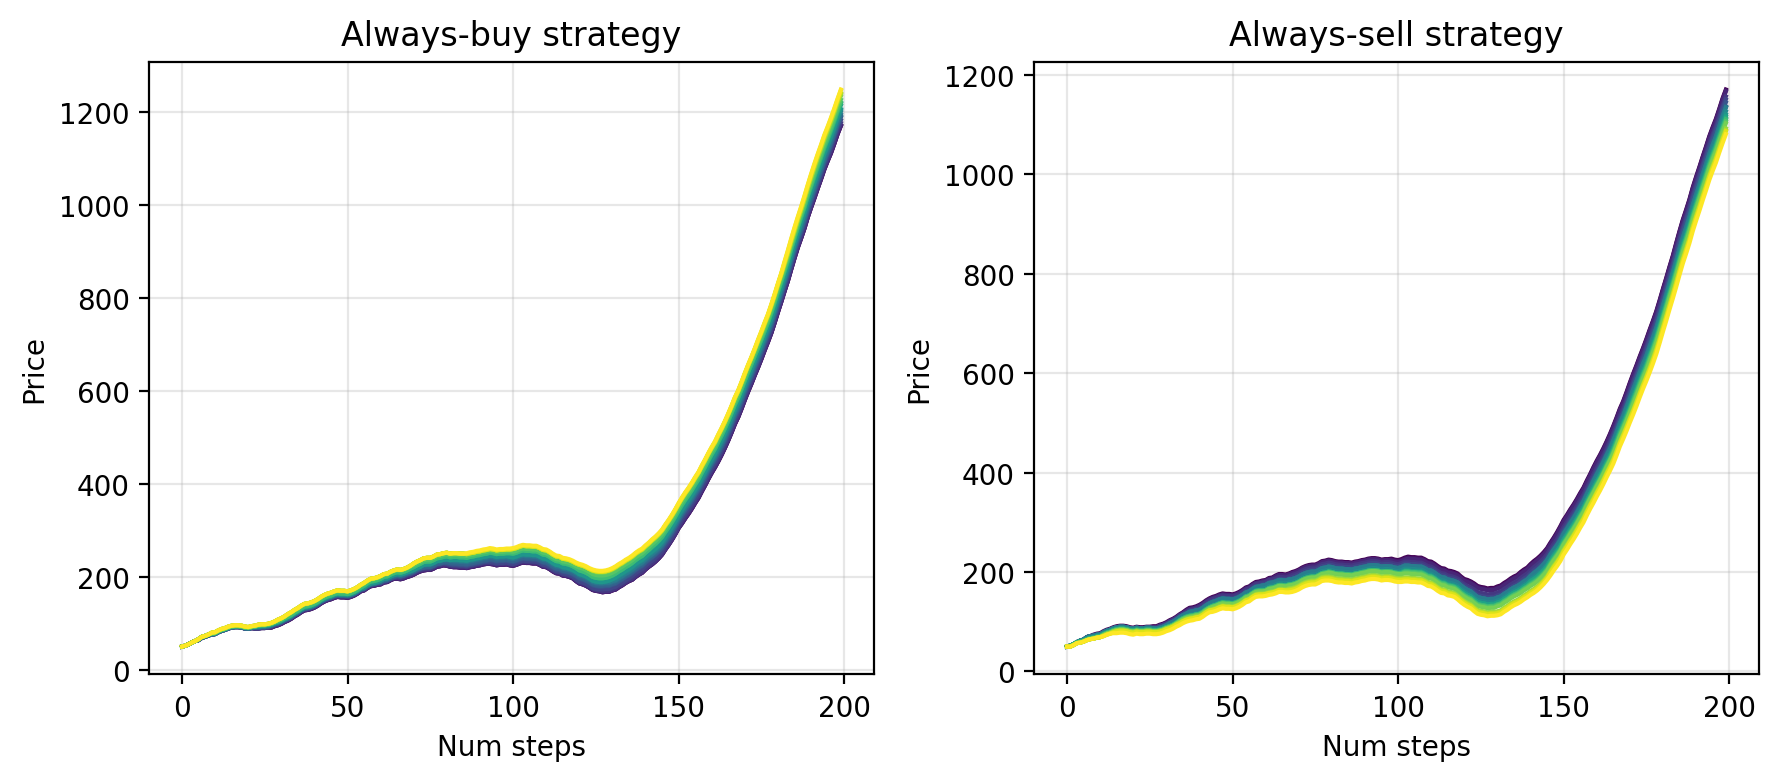

In [88]:
seed = 31415
num_steps = 200
price_init = 50

price_impacts = np.linspace(0, 1, 20)
colors = plt.cm.viridis(price_impacts)
sigma_signal = 1.0

actions_buy = np.ones(num_steps)
actions_sell = -np.ones(num_steps)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
for (price_impact, color) in zip(price_impacts, colors):
    
    prices_buy, signal = price_process(
        seed, num_steps, price_init, actions_buy,
        sigma_signal=sigma_signal, price_impact=price_impact
    )
    ax[0].plot(prices_buy, c=color)
    
    prices_sell, _ = price_process(
        seed, num_steps, price_init, actions_sell,
        sigma_signal=sigma_signal, price_impact=price_impact
    )
    ax[1].plot(prices_sell, c=color)


for axi in ax:
    axi.set_xlabel("Num steps")
    axi.set_ylabel("Price")
    axi.grid(alpha=0.3)

ax[0].set_title("Always-buy strategy")
ax[1].set_title("Always-sell strategy")


plt.tight_layout()

## Value iteration

Action-value function
$$
    q_\pi(s,\,a) = \sum_{s',\,r} p(s',\,r | s,\,a)[r + \gamma v(s')]
$$

In [6]:
@njit
def bern_pmf(y, mu):
    return mu ** y * (1 - mu) ** (1 - y)

@njit
def mdp(
    reward,
    signal_next, inventory_next,
    diff, signal, inventory, action,
    price_impact, temporary_price_impact, inventory_aversion
):
    """
    Markov decision process
    
    Parameters
    ----------
    diff: [-1, 1] — change in the price process
    """
    
    # Probability price transition
    side = (diff + 1) // 2
    
    p_impact = sigmoid(action * price_impact)
    pr_price = bern_pmf(side, p_impact) # either went up or down
    
    # Probability inventory transition
    pr_inventory = (inventory_next == inventory + action)
    
    
    # Probability signal transition
    diff_signal = signal_next - signal
    side_signal = (diff_signal + 1) // 2
    p_signal = 0.5 # Make optional parameter
    pr_signal = bern_pmf(side_signal, p_signal)
    

    # Probability reward
    pr_reward = (
        reward == (
            + (inventory + action) * diff
            - (temporary_price_impact + inventory_aversion) * action ** 2
            - 2 * inventory_aversion * action * inventory
            + (inventory + action) * (signal + diff_signal)
        )
    )
    
    pr = pr_price * pr_inventory * pr_reward * pr_signal
    return pr


@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))

## The action-value function

$$
    q_\pi(s, a) = \sum_{s',r}p(s', r | s, a)[r + \gamma v(s')]
$$

In [1]:
MAX_PRICE = 100 # price in [0, MAX_PRICE]
MAX_INVENTORY = 50 # max inventory per side
MAX_CASH = 50 # max cash per side
MAX_ACTION = 20 # max buy and sell
DISCOUNT = 0.9


@njit
def state_to_position(signal, inventory):
    """
    Transform state values to indices
    in the value-function array
    """
    signal_ix = signal.astype(np.int32)
    inventory_ix = int(inventory + MAX_INVENTORY)
    
    return signal_ix, inventory_ix


@njit
def action_value_function(
    signal, inventory, action, value_function,
    price_impact, temporary_price_impact, inventory_aversion,
):
    
    action = float(action)
    price_changes = np.array([-1.0, 1.0])
    signals_new = np.array([signal - 1.0, signal + 1.0])
    inventory_new = inventory + action
    
    
    rewards = (
        + (inventory + action) * price_changes
        - (temporary_price_impact + inventory_aversion) * action ** 2
        - 2 * inventory_aversion * action * inventory
        + (inventory + action) * signals_new
    )
    

    # p(s', r | s, a)
    mdp_values = mdp(
        rewards, signals_new, inventory_new, price_changes, inventory, action,
        price_impact, temporary_price_impact, inventory_aversion
    )
    
    # signals_new = clip(signals_new, 0.0, MAX_PRICE)
    signals_new = clip(signals_new, -MAX_PRICE, MAX_PRICE) # Signal can be negative
    inventory_new = clip(inventory_new, -MAX_INVENTORY, MAX_INVENTORY)
    
    prices_ix, inventory_ix = state_to_position(signals_new, inventory_new)
    values = value_function[prices_ix, inventory_ix]
        
    value_est = mdp_values * (rewards + DISCOUNT * values)
    
    return value_est.sum()

NameError: name 'njit' is not defined

In [34]:
values_signals = np.arange(-MAX_PRICE, MAX_PRICE + 1)
values_inventory = np.arange(-MAX_INVENTORY, MAX_INVENTORY + 1)
actions = np.arange(-MAX_ACTION, MAX_ACTION + 1)

In [35]:
# price and inventory
value_function = np.zeros((
    # MAX_PRICE + 1,
    2 * MAX_INVENTORY + 1,
    # 2 * MAX_CASH + 1,
))
value_function.shape

(101,)

In [36]:
action_value_function(
    # price=100.0,
    inventory=1.0,
    action=-10,
    value_function=value_function,
    price_impact=0.1,
    temporary_price_impact=1.0,
    inventory_aversion=0.0
)

-95.8409455846599

## Bellman equation for the optimal value function

$$
    v_*(s) = \max_a\sum_{s',r} p(s',r | s, a)[r + \gamma v_*s('s)]
$$

In [39]:
@njit
def value_iteration_state(
    inventory, actions, value_function,
    price_impact, temporary_price_impact, inventory_aversion,
):
    """
    Value iteration for a single given state
    """
    v_max = -np.inf
    action_max = np.nan
    
    for action in actions:
        value = action_value_function(
            inventory, action, value_function,
            price_impact, temporary_price_impact, inventory_aversion
        )
        
        if value > v_max:
            v_max = value
            action_max = action
    
    return v_max, action_max

In [48]:
@njit(parallel=True)
def value_iteration_single(
    inventory_arr, actions, value_function,
    price_impact, temporary_price_impact, inventory_aversion
):
    value_function_update = np.zeros_like(value_function, dtype=np.float64)
    actions_update = np.zeros_like(value_function, dtype=np.int32)
        
    for i_ix in prange(inventory_arr.shape[0]):
        inventory = inventory_arr[i_ix]

        val, action = value_iteration_state(
            inventory, actions, value_function,
            price_impact, temporary_price_impact, inventory_aversion,
        )

        # value_function_update[p_ix, i_ix] = val
        # actions_update[p_ix, i_ix] = action
        value_function_update[i_ix] = val
        actions_update[i_ix] = action

    
    return value_function_update, actions_update

In [49]:
@njit
def value_iteration(
    inventory_arr, actions, value_function_init,
    price_impact, temporary_price_impact, inventory_aversion,
    err_max, max_it=50,
):
    
    value_function = value_function_init.copy()
    errs_hist = []
    for i in range(max_it):
        value_function_new, action_function = value_iteration_single(
            # price_arr=price_arr,
            inventory_arr=inventory_arr,
            actions=actions,
            value_function=value_function,
            price_impact=price_impact,
            temporary_price_impact=temporary_price_impact,
            inventory_aversion=inventory_aversion
        )
        errs = np.abs(value_function - value_function_new)
        value_function = value_function_new
        errs_hist.append(errs.max())
        if errs.max() <= err_max:
            break
    
    return value_function, action_function, np.array(errs_hist)

In [50]:
%%time
# price, inventory, and cash
value_function = np.zeros((
    # MAX_PRICE + 1,
    2 * MAX_INVENTORY + 1,
    # 2 * MAX_CASH + 1,
))

price_impact = 1.0
temporary_price_impact = 1.0
inventory_aversion = 2.0

value_function, action_function, errs_hist = value_iteration(
    # price_arr=values_price,
    inventory_arr=values_inventory,
    actions=actions,
    value_function_init=value_function,
    price_impact=price_impact,
    temporary_price_impact=temporary_price_impact, # 0.0
    inventory_aversion=inventory_aversion,
    err_max=0.2,
    max_it=50
);

CPU times: user 3.26 s, sys: 110 ms, total: 3.37 s
Wall time: 3.04 s


Text(0.5, 1.0, '$\\Delta$ value function')

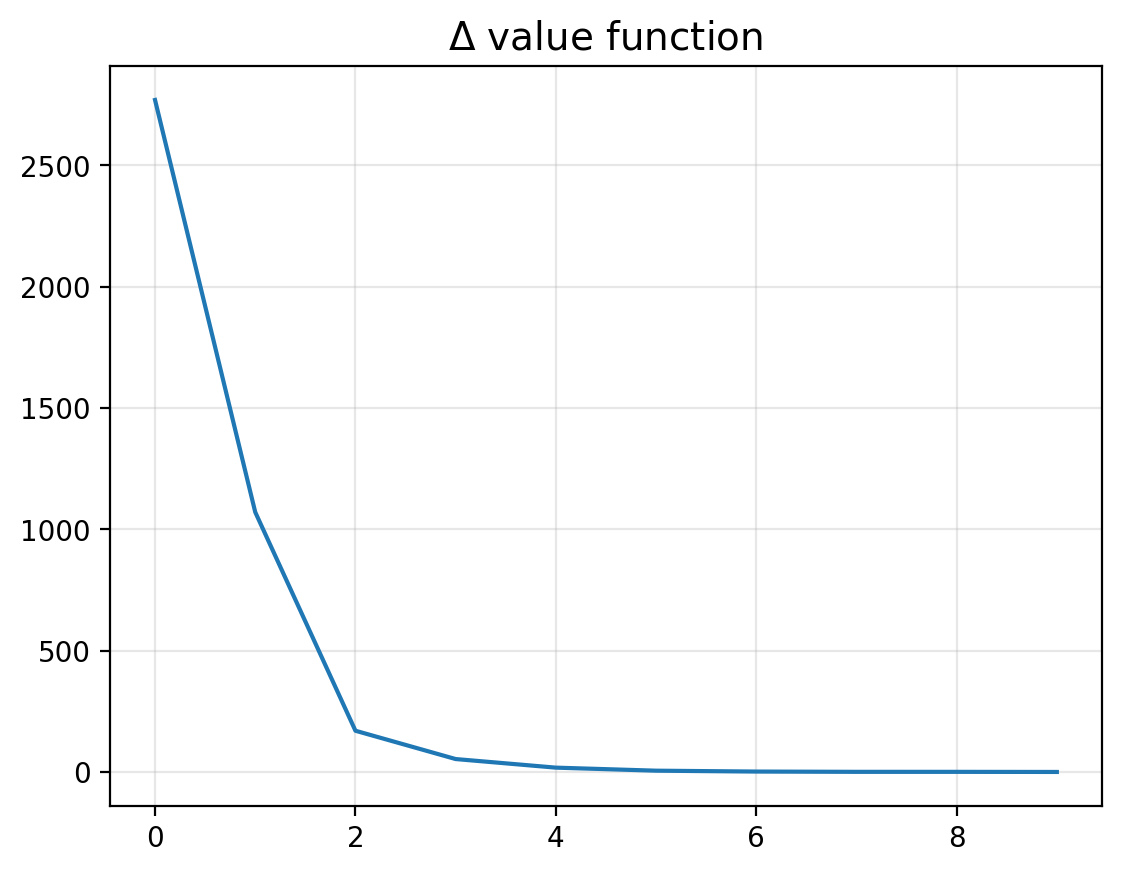

In [51]:
plt.plot(errs_hist)
plt.grid(alpha=0.3)
plt.title("$\Delta$ value function", fontsize=14)

Text(0.5, 1.0, 'Optimal policy')

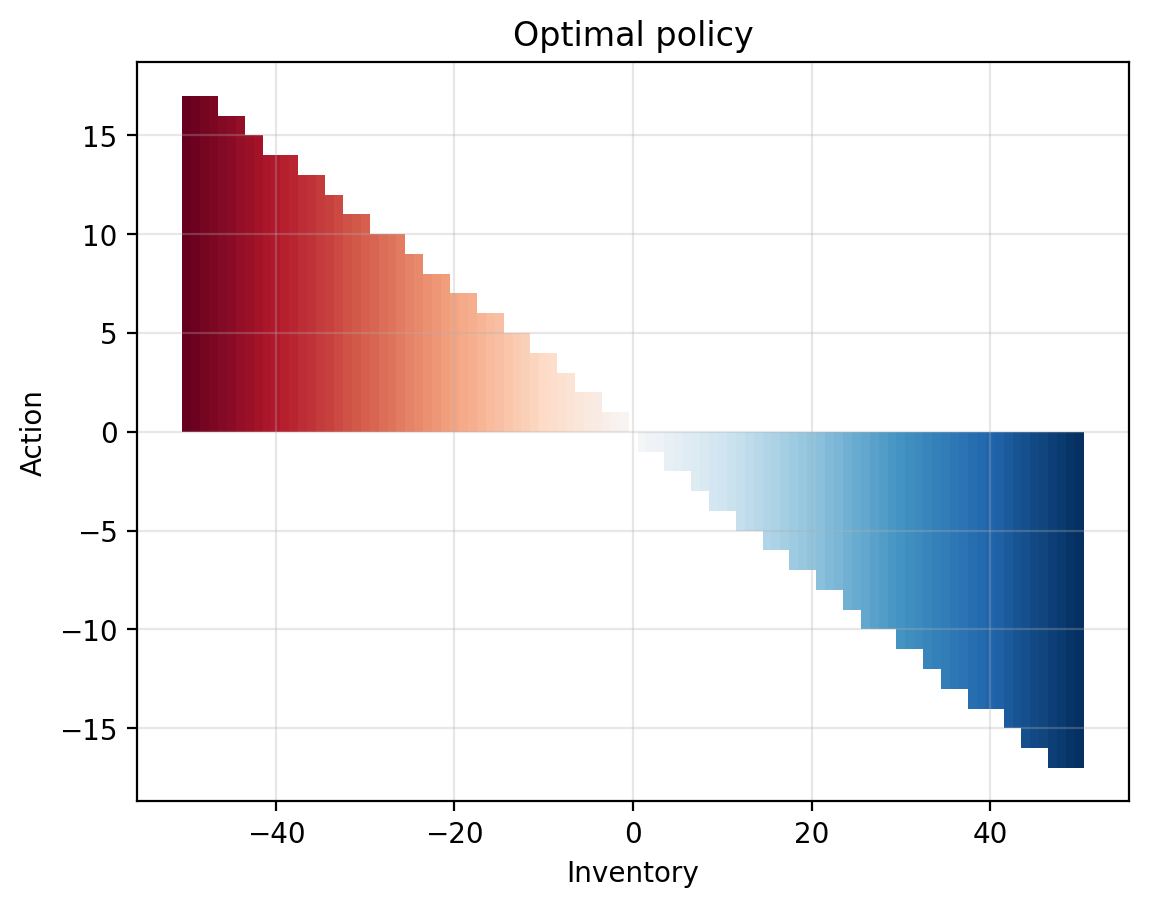

In [83]:
colors = plt.cm.RdBu(np.linspace(0, 1, len(values_inventory)))
plt.bar(values_inventory, action_function, color=colors, width=1.0)
plt.grid(alpha=0.3)
plt.xlabel("Inventory")
plt.ylabel("Action")
plt.title("Optimal policy")

Text(0.5, 1.0, 'Value function')

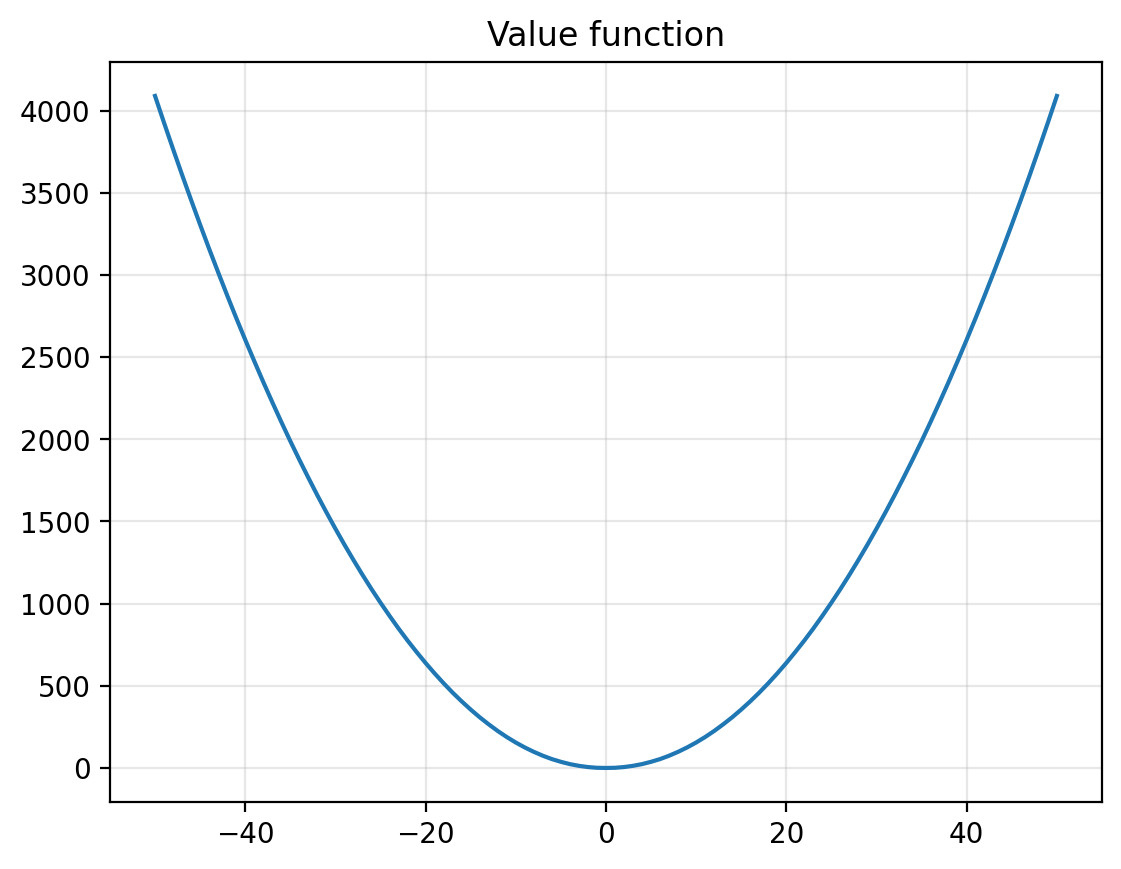

In [84]:
plt.plot(values_inventory, value_function)
plt.grid(alpha=0.3)
# plt.xlabel("Inventory")
# plt.ylabel("Action")
plt.title("Value function")

## Run a simulation

In [71]:
price = 25
inventory = 50
cash = 10

steps = 20
price_hist = np.zeros(steps)
action_hist = np.zeros(steps)
reward_hist = np.zeros(steps)
inventory_hist = np.zeros(steps)
cash_hist = np.zeros(steps)

np.random.seed(314)
for t in range(steps):
    price_ix, inventory_ix = state_to_position(np.array(price), inventory)
    cash_ix = int(cash + MAX_CASH)
    action = action_function[inventory_ix]
    
    cash = cash - action * (price + temporary_price_impact * action)
    price = price_step(price, action, sigma=1.0, delta=1.0, price_impact=price_impact)
    inventory = inventory + action
    
    reward = cash + inventory * price - inventory_aversion * inventory ** 2
    
    price = clip(price, 0.0, MAX_PRICE)
    inventory = clip(inventory, -MAX_INVENTORY, MAX_INVENTORY)
    cash = clip(cash, -MAX_CASH, MAX_CASH)
    
    price_hist[t] = price
    action_hist[t] = action
    reward_hist[t] = reward
    inventory_hist[t] = inventory
    cash_hist[t] = cash

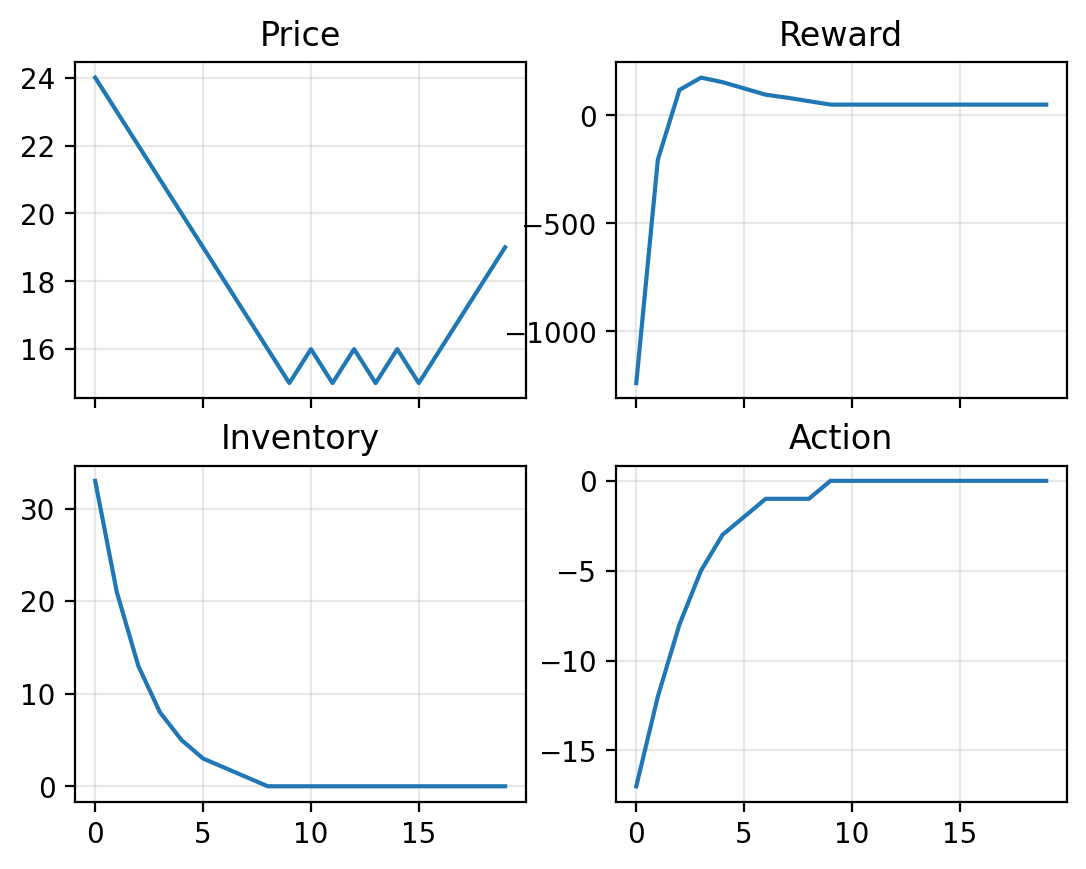

In [72]:
fig, axs = plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

axs[0].plot(price_hist)
axs[1].plot(reward_hist)
axs[2].plot(inventory_hist)
axs[3].plot(action_hist)

labels = ["Price", "Reward", "Inventory", "Action"]
for ax, label in zip(axs, labels):
    ax.grid(alpha=0.3)
    ax.set_title(label)